In [1]:
#Read in standard packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import geopandas as gpd

In [2]:
#importing project specific functions to match changes in EDA notebook
from model_prep import get_feature_name, model_transformer_train

In [3]:
#read in ML packages/modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

In [4]:
#Read in dask package and set up to allow for faster compute times. Distributes computing among all available preocessors
from dask import dataframe as dd
import joblib
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.scheduler, cluster.workers

C:\Users\bwils\anaconda3\envs\pumpitup\lib\site-packages\distributed\node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57740 instead
  warnings.warn(


(<Scheduler: "tcp://127.0.0.1:57743" workers: 4 cores: 8, tasks: 0>,
 {0: <Nanny: tcp://127.0.0.1:57778, threads: 2>,
  1: <Nanny: tcp://127.0.0.1:57775, threads: 2>,
  2: <Nanny: tcp://127.0.0.1:57769, threads: 2>,
  3: <Nanny: tcp://127.0.0.1:57768, threads: 2>})

In [5]:
#read in data from EDA notebook than has been cleaned and new features created
model_data = pd.read_pickle('Data/model_data.pkl')

In [6]:
#check columns available
model_data.columns

Index(['id', 'class', 'amount_tsh', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'basin', 'subvillage', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'scheme_management', 'scheme_name', 'permit', 'extraction_type',
       'management', 'management_group', 'payment_type', 'water_quality',
       'quantity', 'source', 'waterpoint_type', 'water_quality_rank',
       'quantity_rank', 'quant_qual_rank', 'subvillage_rank', 'urban_rural',
       'ward_rank', 'year', 'month', 'years_old', 'fund_inst_same', 'pay_rank',
       'popbins', 'tsh_rank'],
      dtype='object')

# Prepping Data

Now that we have read in the data from the EDA and cleaning step, we need to preprocess it for the model. We will scale the data in the numeric columns gps_height and population so that there larger values don't force them to be unrealistically important features. We will also One Hot Encode our categorical features to allow the model to receive them. Though Random Froest doesn't need this step, our PCA and XGBoost algorithms do.

In [7]:
#remove the id column as it is not used for modeling
#model_data.drop(columns=['year'], inplace=True)

In [8]:
#Create column lists to use as inputs for the StandardScaler and OneHotEncoder Pipeline
num_cols = ['gps_height', 'population', 'amount_tsh', 'years_old']
cat_cols = ['basin', 'region_code', 'district_code', 'extraction_type', 'payment_type', 'water_quality', 'quantity', 
            'source', 'management', 'management_group', 'waterpoint_type',  'funder', 'installer', 'subvillage', 
            'ward', 'scheme_management', 'scheme_name', 'popbins', 'lga', 'urban_rural', 'tsh_rank', 'month']

In [9]:
#Set up instances of StanardSCaler, OneHotEncoder and ColumnTransformer to process model_data
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore')
CT = ColumnTransformer(remainder='passthrough', transformers=[('scaler', scaler, num_cols),
                                              ('ohe', ohe, cat_cols)], verbose=True, sparse_threshold=0)

In [10]:
def prep_train(unprepped_values, class_col):
    #transforms clean data from EDA notebook into model ready train and test data
    train_X, test_X, train_y, test_y = train_test_split(unprepped_values.drop(columns=[class_col]), 
                                                        unprepped_values[class_col], test_size=0.25, random_state=42)
    #run ColumnTransformer fit on training data only
    train_Xct = CT.fit_transform(train_X)
    
    #transform test data based on training fit
    test_Xct = CT.transform(test_X)

    #get columns names from ColumnTransformer
    cols = get_feature_name(CT)
    train_Xf = pd.DataFrame(train_Xct, columns=cols)
    cols = get_feature_name(CT)
    test_Xf = pd.DataFrame(test_Xct, columns=cols)
    
    #Output training and testing dependent and independent variables
    return train_Xf, train_y, test_Xf, test_y   

In [11]:
def prep_submit(unprepped_values):
    #performs the same prepping services as the prep_train function but uses fits from traininig data to transform 
    #the testing data
    #prepares the submission test set as we do our learning set, without refitting to the unseen data
    submit_X= unprepped_values
        
    submit_Xt = model_transformer_train(submit_X)
    submit_Xct = CT.transform(submit_Xt)

    cols = get_feature_name(CT)
    submit_Xf = pd.DataFrame(submit_Xct.todense(), columns=cols)
    
    return submit_Xf

In [12]:
#Run custom function to prep data for model
train_X, train_y, test_X, test_y = prep_train(model_data, 'class')

[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.2s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\gfn.py:36: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


# PCA 

We will start with dimensionality reduction via principal component analysis. We hope this will split out some of the noise in the dataset by focusing on the features that explain the most variance. This will also help with compute time. 

In [13]:
pca = PCA()
pca.fit(train_X)
pca.explained_variance_ratio_[:10]

array([9.99999888e-01, 2.53338479e-08, 1.66711355e-08, 1.21169256e-08,
       8.11815311e-09, 6.66219182e-09, 4.15031139e-09, 3.45361637e-09,
       2.79482216e-09, 2.51740765e-09])

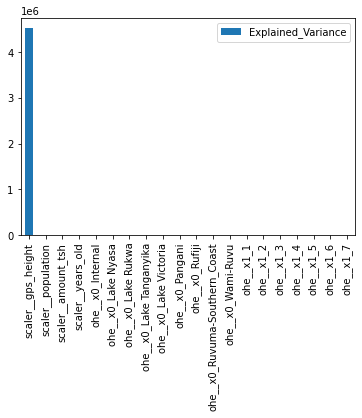

In [14]:
ex_var = pd.DataFrame(pca.singular_values_.reshape(1,-1), columns=train_X.columns, index=['Explained_Variance']).T.sort_values(by='Explained_Variance', ascending=False)
ex_var.head(20).plot(kind='bar')
plt.show()

The two scaler values are the 

### Output for models

In [15]:
train_X.to_pickle('Data/train_test/train_X.pkl')
test_X.to_pickle('Data/train_test/test_X.pkl')
train_y.to_pickle('Data/train_test/train_y.pkl')
test_y.to_pickle('Data/train_test/test_y.pkl')